# Problem Statement : 

# Fake News Classification with The Help Of Natural Language Processing Technique. 
Fake news detection is a hot topic in the field of natural language processing.
We consume news through several mediums throughout the day in our daily routine, but sometimes it becomes difficult to decide which one is fake and which one is authentic. Our job is to create a model which predicts whether a given news is real or fake.

# Required Libraries

In [1]:
try:
    import pandas as pd
    import numpy as np
    import re
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer, WordNetLemmatizer
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud
    import seaborn as sns
    import os
    
except ImportError:
    # If any package is not installed, print an error message or handle it as needed.
    print("Some required packages are not installed! Have a looksie to see if something's missin'!")

In [2]:
# Create the "output" folder to store train and test data as CSV files
current_directory = "PortfolioProject-NLP_Fake_News_Classification"
output_folder = "output"
output_directory = os.path.join(current_directory, output_folder)
os.makedirs(output_directory, exist_ok=True)


# 1. Data Gathering
lets gather the data from the working directory specify the input folder and display it in raw data.

In [7]:
# If coming from a local directory, use this method instead
# df = pd.read_csv("News_dataset.csv")
# df.head()

In [3]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Specify the input folder name
input_folder = "input"

# Specify the CSV filename
csv_filename = "News_dataset.csv"

# Join the current directory, input folder, and CSV filename to get the complete path
csv_path = os.path.join(current_directory, input_folder, csv_filename)

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_path)

# Display the first few rows of the DataFrame
df.head()


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## Data visualization: raw data
 Lets visualize the content as a Cloud of texts to have a first idea of it's content!

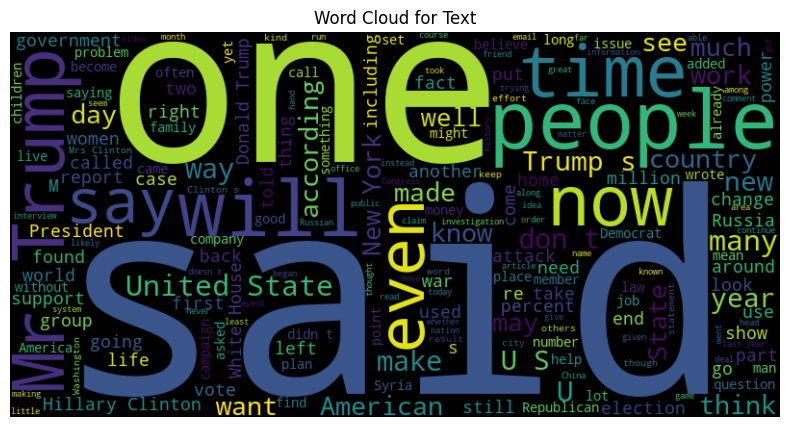

In [6]:
#from wordcloud import WordCloud

# Filter out rows with float values in the 'text' column
text_data = df[df['text'].apply(lambda x: isinstance(x, str))]

# Combine all the text data into a single string (text_corpus)
text_corpus = " ".join(text_data['text'])

# Generate the Word Cloud
wordcloud = WordCloud(width=800, height=400).generate(text_corpus)

# Plot the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Text')
plt.show()


#### Let's quick check the author column and visualize a table version for the names in that column (I suspect there will be some nan characters)

We can clearly see the most repetitive words in the text we re going to analyzed and its relation with the topics to be debunked

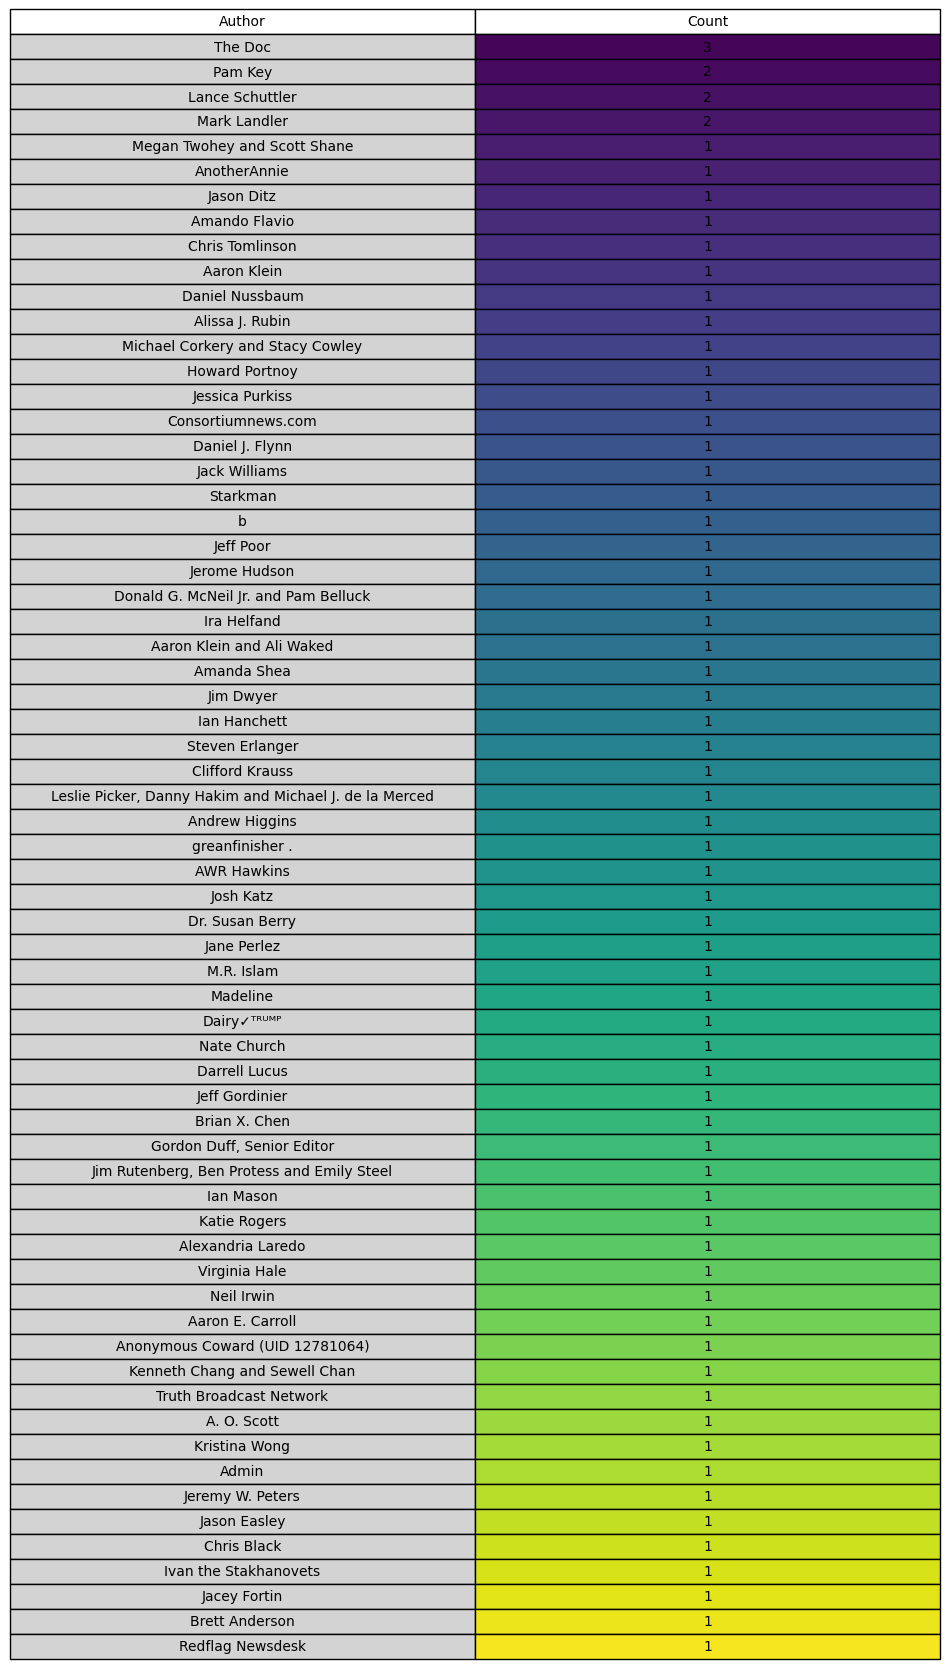

In [50]:
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns

# Get the 'author' column from the DataFrame, Limit the number of rows and Count the occurrences of each name in the 'author' column
author_column = df['author']
max_rows = 80
author_column = author_column[:max_rows]
author_counts = author_column.value_counts()

# Sort the author_counts in descending order
author_counts = author_counts.sort_values(ascending=False)

# Create a figure and axis for the table
fig, ax = plt.subplots(figsize=(8, 6))

# Hide the axis and remove unnecessary spines
ax.axis('off')

# Create a viridis color palette
n_colors = len(author_counts)
viridis_palette = sns.color_palette('viridis', n_colors=n_colors)

# Create the table with the 'author' column data and counts
table_data = [[author, count] for author, count in zip(author_counts.index, author_counts.values)]
table = ax.table(cellText=table_data, colLabels=['Author', 'Count'], cellLoc='center', loc='center', cellColours=[['lightgray', viridis_palette[i]] for i in range(n_colors)])

# Set the font size for the table cells
table.auto_set_font_size(False)
table.set_fontsize(10)

# Adjust the cell heights to make the table look better
table.scale(1.5, 1.5)

# Show the table
plt.show()


* we can immediately see that the diversity of authors is wide and only a few authors 'The Doc', 'Pam key', 'Lance Shuttler' and 'Mark landler' are more frequent than the other entries in the author column. Lets explore a bit more.

#### These are the Top 30 Authors in the Dataset

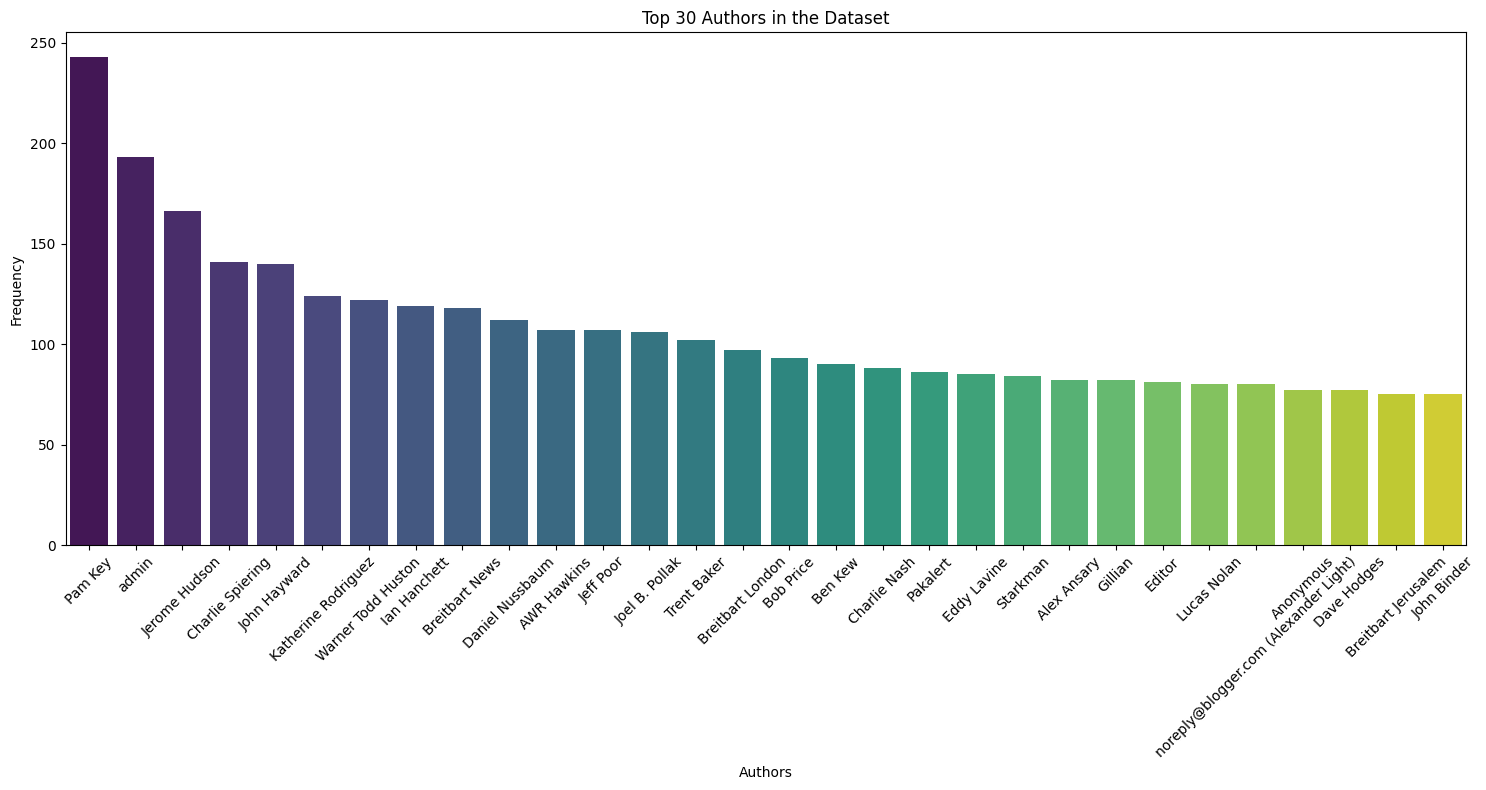

In [51]:
#import pandas as pd
#import seaborn as sns
#import matplotlib.pyplot as plt


# Get the 'author' column from the DataFrame
author_column = df['author']

# Count the occurrences of each name in the 'author' column
author_counts = author_column.value_counts()

# Limit the number of authors to be displayed in the bar plot
max_authors = 30
top_authors = author_counts.head(max_authors)

# Create a bar plot for the top authors using Seaborn
plt.figure(figsize=(15, 8))
sns.barplot(x=top_authors.index, y=top_authors.values, palette='viridis') # because i love viridis!
plt.xlabel('Authors')
plt.ylabel('Frequency')
plt.title(f'Top {max_authors} Authors in the Dataset')
plt.xticks(rotation=45)  # Rotate the author names for better visibility (I love the 45 degree rotation on barplots!)
plt.tight_layout()
plt.show()


# 2. Data Analysis

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [53]:
df['label'].value_counts()

label
1    10413
0    10387
Name: count, dtype: int64

In [54]:
df.shape

(20800, 5)

In [55]:
df.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [56]:
df = df.dropna() #Handled Missing values by droping those rows

In [57]:
df.isna().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [58]:
df.shape

(18285, 5)

In [59]:
df.reset_index(inplace=True)
df.head()

,index,id,title,author,text,label
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [60]:
df['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [61]:
df = df.drop(['id','text','author'],axis = 1)
df.head()

,index,title,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0
2,2,Why the Truth Might Get You Fired,1
3,3,15 Civilians Killed In Single US Airstrike Hav...,1
4,4,Iranian woman jailed for fictional unpublished...,1


# 3. Data Preprocessing

## 1.Tokenization

In [62]:
sample_data = 'The quick brown fox jumps over the lazy dog'
sample_data = sample_data.split()
sample_data

['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

## 2. Make Lowercase

In [63]:
sample_data = [data.lower() for data in sample_data]
sample_data

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

## 3. Remove Stopwords

In [64]:
# lets re-import Stopwords from nltk library (why? because its giving me the same issue of not loading the specific resource within nltk *shrug*).
nltk.download('stopwords')


stopwords = stopwords.words('english')
print(stopwords[0:10])
print(len(stopwords))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
179


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JorgeAmaya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
sample_data = [data for data in sample_data if data not in stopwords]
print(sample_data)
len(sample_data)

['quick', 'brown', 'fox', 'jumps', 'lazy', 'dog']


6

## 4. Stemming

In [66]:
ps = PorterStemmer()
sample_data_stemming = [ps.stem(data) for data in sample_data]
print(sample_data_stemming)

['quick', 'brown', 'fox', 'jump', 'lazi', 'dog']


## 5. Lemmatization

In [67]:
#same here. I need to download the specific resource. *shrug again*

nltk.download('wordnet')


lm = WordNetLemmatizer()
sample_data_lemma = [lm.lemmatize(data) for data in sample_data]
print(sample_data_lemma)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JorgeAmaya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['quick', 'brown', 'fox', 'jump', 'lazy', 'dog']


In [68]:
lm = WordNetLemmatizer()
corpus = []
for i in range (len(df)):
    review = re.sub('^a-zA-Z0-9',' ', df['title'][i])
    review = review.lower()
    review = review.split()
    review = [lm.lemmatize(x) for x in review if x not in stopwords]
    review = " ".join(review)
    corpus.append(review)

In [69]:
len(corpus)

18285

In [70]:
df['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [71]:
corpus[0]

'house dem aide: didn’t even see comey’s letter jason chaffetz tweeted'

# 4. Vectorization (Convert Text data into the Vector)

In [72]:
tf = TfidfVectorizer()
x = tf.fit_transform(corpus).toarray()
x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [73]:
y = df['label']
y.head()

0    1
1    0
2    1
3    1
4    1
Name: label, dtype: int64

## Data splitting into the train and test

In [74]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 10, stratify = y )

In [75]:
len(x_train),len(y_train)

(12799, 12799)

In [76]:
len(x_test), len(y_test)

(5486, 5486)

# 5. Model Building

In [77]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

# 6. Model Evaluation

In [97]:
y_pred = rf.predict(x_test)
accuracy_score_ = accuracy_score(y_test,y_pred) 
accuracy_score_

0.9382063434196135

In [98]:
class Evaluation:
    
    def __init__(self,model,x_train,x_test,y_train,y_test):
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        
    def train_evaluation(self):
        y_pred_train = self.model.predict(self.x_train)
                
        acc_scr_train = accuracy_score(self.y_train,y_pred_train)
        print("Accuracy Score On Training Data Set :",acc_scr_train)
        print()
        
        con_mat_train = confusion_matrix(self.y_train,y_pred_train)
        print("Confusion Matrix On Training Data Set :\n",con_mat_train)
        print()
        
        class_rep_train = classification_report(self.y_train,y_pred_train)
        print("Classification Report On Training Data Set :\n",class_rep_train)
        
        
    def test_evaluation(self):
        y_pred_test = self.model.predict(self.x_test)
        
        acc_scr_test = accuracy_score(self.y_test,y_pred_test)
        print("Accuracy Score On Testing Data Set :",acc_scr_test)
        print()
        
        con_mat_test = confusion_matrix(self.y_test,y_pred_test)
        print("Confusion Matrix On Testing Data Set :\n",con_mat_test)
        print()
        
        class_rep_test = classification_report(self.y_test,y_pred_test)
        print("Classification Report On Testing Data Set :\n",class_rep_test)       
        

## Lets have a looksie at one branch of the decition tree

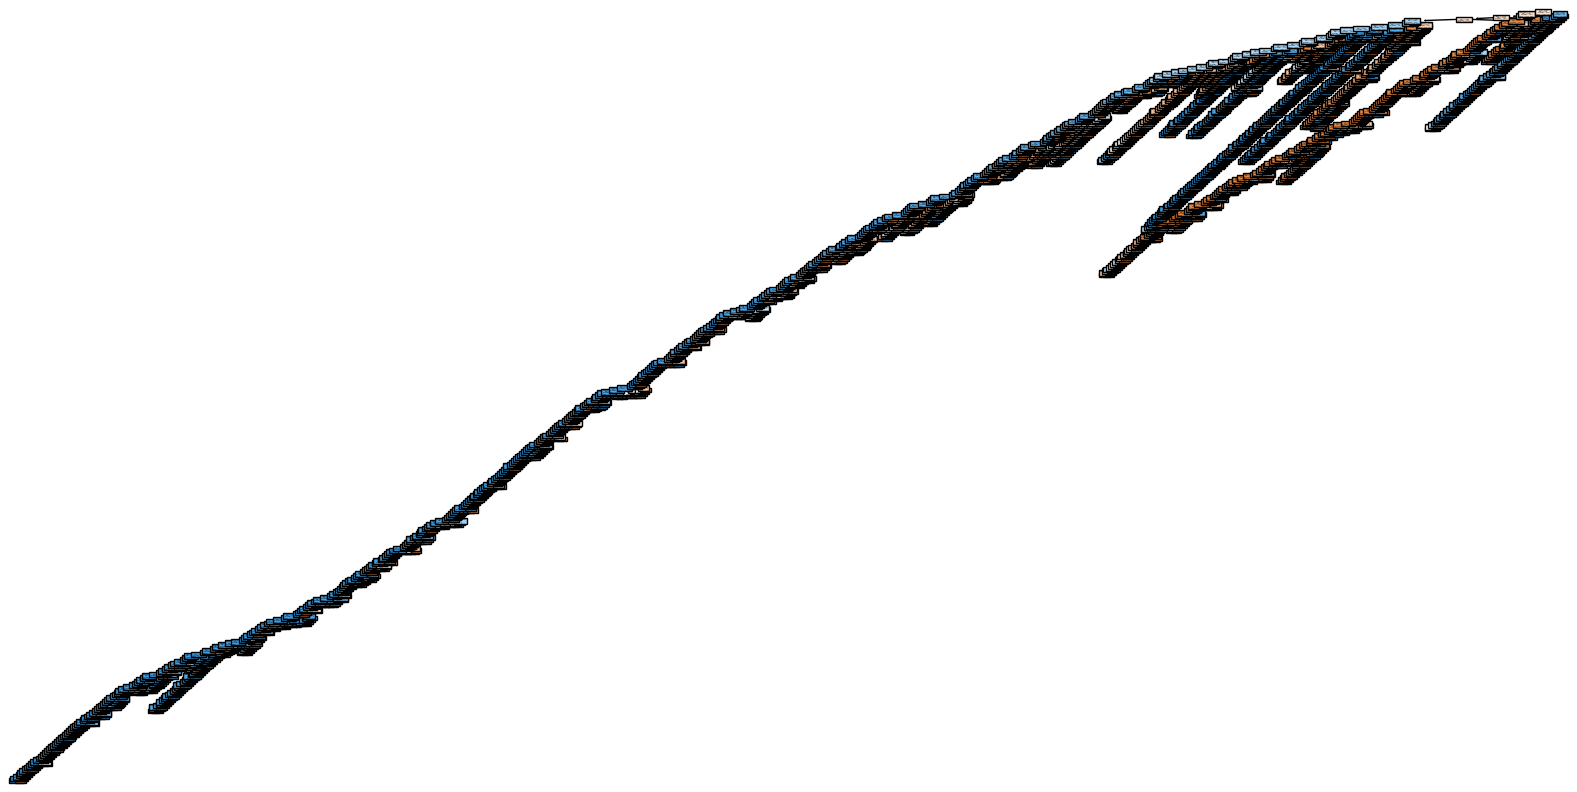

In [79]:
from sklearn.tree import plot_tree

# with the random forest classifier 'rf' trained

# Extract one of the decision trees from the random forest (e.g., the first tree)
one_tree = rf.estimators_[0]

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(one_tree, filled=True, feature_names=tf.get_feature_names_out().tolist())
plt.show()



In [99]:
'''
# Formato de reporte simplificado:
# Create an Evaluation object
evaluation = Evaluation(rf, x_train, x_test, y_train, y_test)

# Call the train_evaluation and test_evaluation methods to print the results
print("Training Dataset Evaluation:")
evaluation.train_evaluation()

print("\nTesting Dataset Evaluation:")
evaluation.test_evaluation()
'''

'\n# Formato de reporte simplificado:\n# Create an Evaluation object\nevaluation = Evaluation(rf, x_train, x_test, y_train, y_test)\n\n# Call the train_evaluation and test_evaluation methods to print the results\nprint("Training Dataset Evaluation:")\nevaluation.train_evaluation()\n\nprint("\nTesting Dataset Evaluation:")\nevaluation.test_evaluation()\n'

### Checking the accuracy on training dataset

In [100]:
#Checking the accuracy on training dataset

Evaluation(rf,x_train, x_test, y_train, y_test).train_evaluation()


Accuracy Score On Training Data Set : 1.0

Confusion Matrix On Training Data Set :
 [[7252    0]
 [   0 5547]]

Classification Report On Training Data Set :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7252
           1       1.00      1.00      1.00      5547

    accuracy                           1.00     12799
   macro avg       1.00      1.00      1.00     12799
weighted avg       1.00      1.00      1.00     12799



In [112]:
### visualizing the accuracy of the training dataset ploting learning curve:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, train_sizes, cv, scoring):
    train_sizes_abs, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring=scoring
    )

    # Calculate mean and standard deviation for training and testing scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes_abs, train_scores_mean, 'o-', color='r', label='Training Score')
    plt.fill_between(
        train_sizes_abs,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1, color='r'
    )
    plt.plot(train_sizes_abs, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
    plt.fill_between(
        train_sizes_abs,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1, color='g'
    )
    plt.xlabel('Training Set Size')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Assuming you have the random forest classifier 'rf', and the train and test datasets
train_sizes = np.linspace(0.1, 1.0, 10)  # Adjust the range as needed
plot_learning_curve(rf, x_train, y_train, train_sizes, cv=5, scoring='accuracy')


### Checking the accuracy on testing dataset

In [101]:
#Checking the accuracy on testing dataset
Evaluation(rf,x_train, x_test, y_train, y_test).test_evaluation()

Accuracy Score On Testing Data Set : 0.9382063434196135

Confusion Matrix On Testing Data Set :
 [[2829  280]
 [  59 2318]]

Classification Report On Testing Data Set :
               precision    recall  f1-score   support

           0       0.98      0.91      0.94      3109
           1       0.89      0.98      0.93      2377

    accuracy                           0.94      5486
   macro avg       0.94      0.94      0.94      5486
weighted avg       0.94      0.94      0.94      5486



In [ ]:
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Assuming you have predictions for the test data
y_pred = rf.predict(x_test)

# Plot the confusion matrix heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Plot the precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, rf.predict_proba(x_test)[:, 1])
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


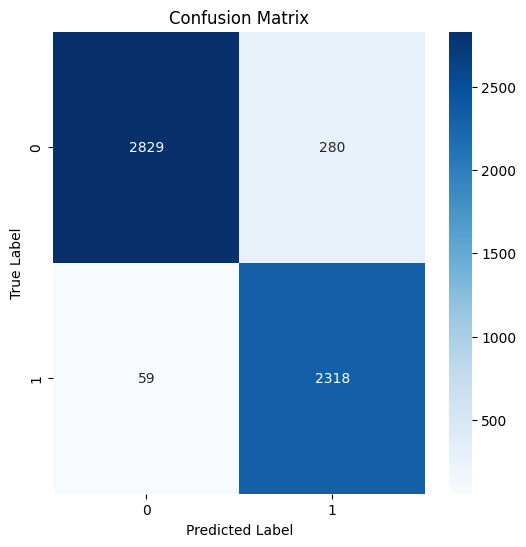

In [102]:
# Assuming you have trained the model and predicted on test data we can now see our matrix of predictions
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Prediction Pipeline

In [103]:
class Preprocessing:
    
    def __init__(self,data):
        self.data = data
        
    def text_preprocessing_user(self):
        lm = WordNetLemmatizer()
        pred_data = [self.data]    
        preprocess_data = []
        for data in pred_data:
            review = re.sub('^a-zA-Z0-9',' ', data)
            review = review.lower()
            review = review.split()
            review = [lm.lemmatize(x) for x in review if x not in stopwords]
            review = " ".join(review)
            preprocess_data.append(review)
        return preprocess_data    

In [104]:
df['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [105]:
data = 'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'
Preprocessing(data).text_preprocessing_user()

['flynn: hillary clinton, big woman campus - breitbart']

In [106]:
class Prediction:
    
    def __init__(self,pred_data, model):
        self.pred_data = pred_data
        self.model = model
        
    def prediction_model(self):
        preprocess_data = Preprocessing(self.pred_data).text_preprocessing_user()
        data = tf.transform(preprocess_data)
        prediction = self.model.predict(data)
        
        if prediction [0] == 0 :
            return "The News Is Fake"
        
        else:
            return "The News Is Real"
        

In [107]:
data = 'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'
Prediction(data,rf).prediction_model()

'The News Is Fake'

In [108]:
df['title'][3]

'15 Civilians Killed In Single US Airstrike Have Been Identified'

In [109]:
user_data = '15 Civilians Killed In Single US Airstrike Have Been Identified' 
Prediction(user_data,rf).prediction_model()

'The News Is Real'

In [110]:
# quick check

print("Shape of x_test:", x_test.shape)
print("Shape of y_pred:", y_pred.shape)


Shape of x_test: (5486, 19259)
Shape of y_pred: (5486,)


#### Lets make this graphics WORKS!!!!

In [111]:
# Convert x_train from a NumPy array to a list of strings
x_train = x_train.tolist()

# Assuming you have separate training and testing data
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_test = tfidf_vectorizer.transform(x_test)

# Get the top TF-IDF words for each class
top_words_per_class = {}
for label in df['label'].unique():
    tfidf_scores = tfidf_train[y_train == label].mean(axis=0).A1
    top_indices = tfidf_scores.argsort()[-10:]
    top_words = [tfidf_vectorizer.get_feature_names()[i] for i in top_indices]
    top_words_per_class[label] = top_words

# Plot the top TF-IDF words for each class
for label, top_words in top_words_per_class.items():
    plt.figure(figsize=(8, 4))
    plt.barh(top_words, tfidf_vectorizer.transform([top_words]).toarray()[0])
    plt.title(f'Top TF-IDF Words for {label}')
    plt.xlabel('TF-IDF Score')
    plt.show()



AttributeError: 'list' object has no attribute 'lower'

#### Lets try saving the output somewhere...

In [ ]:
# Save the final output as a CSV file in the "output" folder
final_output_data = pd.DataFrame(data=df["title"], columns=["title"])
final_output_data["label"] = y_pred
final_output_data.index = x_test.index  # Set the same indices as x_test
final_output_data.to_csv(os.path.join(output_directory, "final_output.csv"), index=False)


ValueError: Length of values (5486) does not match length of index (18285)